In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pmdarima


     |████████████████████████████████| 1.4 MB 4.3 MB/s 
     |████████████████████████████████| 9.8 MB 39.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pmdarima as pm


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
from scipy.stats import binom
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

In [ ]:
pathdata="CPI_review.csv"
data=pd.read_csv(pathdata,sep=',')

In [ ]:
cpi=data.to_numpy()
idx_mn=np.array(cpi[:,0])
idx_dy=np.array(cpi[:,1])
idx_yr=np.array(cpi[:,2])
cpi_data=np.array(cpi[:,3])

cpi_mnly_train=[]
cpi_mnly_test=[]
cpi_mnly_train.append(cpi_data[0])
pre_mn=idx_mn[0]

train_end=9+12*2012
use_train=True

target=1.0+12*2013.0


for i in range(len(cpi_data)):
  
    if (idx_mn[i]+(idx_yr[i]-1)*12)>=train_end:
        
        use_train=False
        
    if idx_mn[i]!=pre_mn:
        if use_train:
            cpi_mnly_train.append(cpi_data[i])
            #print(idx_mn[i], idx_yr[i])
        else:
            cpi_mnly_test.append(cpi_data[i])
            #print(idx_mn[i], idx_yr[i])
            
        pre_mn=idx_mn[i]
        
   

count_train=[]
for i in range(len(cpi_mnly_train)):
    count_train.append(i)

count_test=[]
for i in range(len(cpi_mnly_test)):
    count_test.append(i+count_train[-1]+1)


In [ ]:
##### Figure #####    
fig1, ax1 = plt.subplots(1,1)

ax1.plot(count_train, cpi_mnly_train)
ax1.set(xlabel='time index', ylabel='CPI',
       title='CPI') 
ax1.grid()
plt.show()
### End Figure ###


##### Figure #####   
fig2, ax2 = plt.subplots(1,1)

ax2.plot(count_train, cpi_mnly_train, count_test, cpi_mnly_test)
ax2.set(xlabel='Month', ylabel='Monthly CPI',
       title='CPI') 
ax2.grid()
plt.show()

##### End Figure #####   


In [ ]:
count_train=np.array(count_train)
cpi_mnly_train=np.array(cpi_mnly_train)

count_test=np.array(count_test)
cpi_mnly_test=np.array(cpi_mnly_test)

##########Linear Regression####################
print(" ")
print("##### Linear Regression #####")      
cpi_reg=LinearRegression().fit(count_train.reshape(-1,1),cpi_mnly_train.reshape(-1,1))
theta=cpi_reg.coef_[0][0]
theta_0=cpi_reg.intercept_[0]
print("Theta= ",theta)
print("Theta_0= ",theta_0)

pred_train=theta*count_train+theta_0

#cpi_reg_test=LinearRegression().fit(count_test.reshape(-1,1),cpi_mnly_test.reshape(-1,1))
theta_test=cpi_reg.coef_[0][0]
theta_0_test=cpi_reg.intercept_[0]

print("Theta_test= ",theta_test)
print("Theta_0_test= ",theta_0_test)

pred_test=theta_test*count_test+theta_0_test


 
##### Linear Regression #####
Theta=  0.16104348366951218
Theta_0=  96.72932632872504
Theta_test=  0.16104348366951218
Theta_0_test=  96.72932632872504


In [ ]:
##### Figure #####   
fig3, ax3 = plt.subplots(1,1)
ax3.scatter(count_train, cpi_mnly_train)
ax3.plot(count_train, pred_train, color='orange')
ax3.set(xlabel='time index)', ylabel='CPI',
       title='CPI trend') 
ax3.grid()
plt.show()

##### End Figure #####   


In [ ]:
resid_train=cpi_mnly_train-(pred_train)
resid_test=cpi_mnly_test-(pred_test)
resid_all=np.concatenate((resid_train,resid_test))


In [ ]:
##### Figure #####   
fig4, ax4 = plt.subplots(1,1)
ax4.scatter(count_train, resid_train)
ax4.scatter(count_test, resid_test, color='orange')
ax4.set(xlabel='time index', ylabel='Prediction error',
       title='CPI') 
ax4.grid()
plt.show()

##### End Figure #####   


In [ ]:
resid_max=np.max(abs(resid_train))

print("Max Resid train= ",resid_max)

Max Resid train=  3.6347301876054416


In [ ]:
##### Plot ACF #####

sm.graphics.tsa.plot_acf(resid_train, lags=40)
#plt.show()

##### Plot PACF #####
sm.graphics.tsa.plot_pacf(resid_train, lags=5, method="ywm")
#plt.show()

###########Fit AutoRegressive Model

In [ ]:
window=2
#########Train #################
print(" ")
print("##### AutoRegressive Model Fit #####")
model_train = AutoReg(resid_train, old_names=True, lags=window, trend="n")
resid_train_fit=model_train.fit()
coef = resid_train_fit.params
print('AR Coefficients: %s' % coef)

pred_resid_train = resid_train_fit.predict(start=0, end=len(resid_train)-1, dynamic=False)

#########Test #################

reg_all=AutoReg(resid_all, old_names=True, lags=window, trend="n")
pred_resid_test=reg_all.predict(resid_train_fit.params, start=len(resid_train), end=len(resid_all)-1, dynamic=False)


history = resid_train[len(resid_train)-window:].flatten()

history = [history[i] for i in range(len(history))]

pred_test = list()

for t in range(len(resid_test)):
    length = len(history)
    lag = [history[i] for i in range(length - window, length)]
    
    yhat = .0
    if t == 0:
        for d in range(window):
            yhat += coef[d] * (lag[window - d - 1] - pred_resid_train[-2])
        yhat += pred_train[-2]
    elif t == 1:
        for d in range(window):
            yhat += coef[d] * (lag[window - d - 1] - pred_resid_train[-1])
        yhat += pred_train[-1]
    else:
        for d in range(window):
            yhat += coef[d] * (lag[window - d - 1] - pred_resid_test[t-2])
        yhat += pred_test[t-2]
    obs=resid_test[t]
    pred_test.append(yhat)
    history.append(obs)
    
    #print('predicted={}, expected={}'.format(yhat, cpi_mnly_test[t]))

##### Calculate RMSE error ##############

error_meansq=mean_squared_error(cpi_mnly_test, pred_test,squared=False)
print("RMSE= ",error_meansq)

error_meanpct=mean_absolute_percentage_error(cpi_mnly_test, pred_test)
print("MAPE(%)= ",error_meanpct*100)



 
##### AutoRegressive Model Fit #####
AR Coefficients: [ 1.3355459  -0.54056721]
RMSE=  11.917507199341545
MAPE(%)=  8.775993730119861


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:236: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:236: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  FutureWarning,


# Inflation Rate

In [ ]:
IR_train=[]
for i in range(1, len(count_train)):
    IR_train.append((cpi_mnly_train[i]-cpi_mnly_train[i-1])/cpi_mnly_train[i-1])

IR_test=[]
for i in range(0, len(count_test)):
    if i==0:
        IR_test.append((cpi_mnly_test[i]-cpi_mnly_train[-1])/cpi_mnly_train[-1])
    else:
        IR_test.append((cpi_mnly_test[i]-cpi_mnly_test[i-1])/cpi_mnly_test[i-1])
    
cpi_0213=105.2396
cpi_0113=104.9293

IR_0213=100*(cpi_0213-cpi_0113)/cpi_0113  #unit=%#

print("inflation rate Feb 2013= ",IR_0213)

LogIR_0213=100*(np.log(cpi_0213)-np.log(cpi_0113))
print("Log inflation rate Feb 2013= ",LogIR_0213)

IR_prct_train=[ele * 100 for ele in IR_train]
IR_prct_test=[ele * 100 for ele in IR_test]


inflation rate Feb 2013=  0.2957229296297583
Log inflation rate Feb 2013=  0.2952865295193341


In [ ]:
##### Figure #####
fig8, ax8 = plt.subplots(1,1)
ax8.plot(count_train[1:], IR_prct_train, label="train")
ax8.plot(count_test, IR_prct_test, label="validation")

ax8.set(xlabel='month', ylabel='Inflation Rate (%)',
       title='Monthly inflation rate in percentage') 
ax8.legend(loc="lower right")
ax8.grid()
plt.show()
##### End Figure #####

In [ ]:
count_ir_train=np.array(count_train[1:])
IR_prct_train=np.array(IR_prct_train)

count_ir_test=np.array(count_test)

print(" ")
print("##### Linear Regression Training #####")      
ir_reg=LinearRegression().fit(count_ir_train.reshape(-1,1),IR_prct_train.reshape(-1,1))
theta_ir_train=ir_reg.coef_[0][0]
theta_0_ir_train=ir_reg.intercept_[0]
print("Theta_IR= ",theta_ir_train)
print("Theta_0_IR= ",theta_0_ir_train)

pred_ir_train=theta_ir_train*count_ir_train+theta_0_ir_train

resid_ir_train=IR_prct_train-pred_ir_train

print(" ")
print("##### Linear Regression Test #####")      
count_ir_test=np.array(count_ir_test)
IR_prct_test=np.array(IR_prct_test)

ir_reg_test=LinearRegression().fit(count_ir_test.reshape(-1,1),IR_prct_test.reshape(-1,1))
theta_ir_test=ir_reg_test.coef_[0][0]
theta_0_ir_test=ir_reg.intercept_[0]
print("Theta_IR test= ",theta_ir_test)
print("Theta_0_IR test= ",theta_0_ir_test)

pred_ir_test=theta_ir_test*count_ir_test+theta_0_ir_test

resid_ir_test=IR_prct_test-pred_ir_test

resid_ir_all=np.concatenate((resid_ir_train,resid_ir_test))

count_all=np.concatenate((count_train[1:], count_test))
IR_prct_all=np.concatenate((IR_prct_train, IR_prct_test))


 
##### Linear Regression Training #####
Theta_IR=  0.0054937024691356084
Theta_0_IR=  -0.062055837951468004
 
##### Linear Regression Test #####
Theta_IR test=  0.0019194336243975258
Theta_0_IR test=  -0.062055837951468004


In [ ]:
##### Figure #####
fig9, ax9 = plt.subplots(1,1)
ax9.plot(count_train[1:], IR_prct_train, label="raw train", color="blue")
ax9.plot(count_train[1:], resid_ir_train, label="detrended train", color="purple")


ax9.set(xlabel='month', ylabel='Inflation Rate (%)',
       title='Detrended Monthly inflation rate in percentage') 
ax9.legend(loc="lower right")
ax9.grid()
plt.show()
##### End Figure #####


In [ ]:
##### Plot PACF of IR #####

sm.graphics.tsa.plot_pacf(resid_ir_train, lags=5, method="ywm" ,  title="PACF of residual inflation rate")



In [ ]:
##### Figure #####
fig12, ax12 = plt.subplots(1,1)
ax12.plot(count_test, IR_prct_test, label="raw validation", color="blue")
ax12.plot(count_test, resid_ir_test, label="detrended validation", color="purple")


ax12.set(xlabel='month', ylabel='Inflation Rate (%)',
       title='Detrended Monthly inflation rate in percentage') 
ax12.legend(loc="lower right")
ax12.grid()
plt.show()
##### End Figure #####

Autoregressive Model AR(2)

In [ ]:
###########################
# AR(2) model
###########################
error_rmse=np.zeros(3)

window=2
#########Train #################
print(" ")
print("##### AutoRegressive Model Fit #####")
model_ir_train = AutoReg(resid_ir_train, old_names=True, lags=window, trend="n")
resid_ir_train_fit=model_ir_train.fit()
coef = resid_ir_train_fit.params
print('AR Coefficients for IR: %s' % coef)
out = 'AIC: {0:0.3f}, BIC: {2:0.3f}'
print("p=2: AIC= {0:2.3f}, BIC={1:2.3f}".format(resid_ir_train_fit.aic, resid_ir_train_fit.bic))

pred_resid_ir_train = resid_ir_train_fit.predict(start=2, end=len(resid_ir_train), dynamic=False)


 
##### AutoRegressive Model Fit #####
AR Coefficients for IR: [ 0.64875067 -0.26154762]
p=2: AIC= 53.962, BIC=60.195


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:236: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  FutureWarning,


In [ ]:
##### Figure #####
fig11, ax11 = plt.subplots(1,1)

ax11.plot(count_train[2:], resid_ir_train[1:], label="detrended train", color="purple")
ax11.plot(count_train[2:], pred_resid_ir_train, label="predicted residual train", color="red")

ax11.set(xlabel='month', ylabel='Residual Inflation Rate (%)',
       title='Fitted Residual Monthly inflation rate in %') 
ax11.legend(loc="lower right")
ax11.grid()
plt.show()
##### End Figure #####


In [ ]:
################Prediction (AR(2)) of Inflation Rate #########

window=2
pred_resid_ir_test = list()

history=resid_ir_train[len(resid_ir_train)-window:]
history=[history[i] for i in range(len(history))]

for t in range(len(resid_ir_test)):
    length=len(history)
    lag=[history[i] for i in range(length-window,length)]
    pred_hat=0
    for d in range(window):
        pred_hat+=coef[d]*lag[window-d-1]
    if t>1:
        obs=resid_ir_test[t]
        history.append(obs)
    pred_resid_ir_test.append(pred_hat)
    
    #print('predicted={0:.3f}, expected={1:.3f}'.format(pred_hat, obs))


In [ ]:
##### Figure #####

fig13, ax13 = plt.subplots(1,1)

ax13.plot(count_test, resid_ir_test, label="detrended residual validation", color="green")
ax13.plot(count_test, pred_resid_ir_test, label="predicted residual validation", color="cyan")

ax13.set(xlabel='month', ylabel='Residual Inflation Rate (%)',
       title='Fitted Residual Monthly inflation rate in %') 
ax13.legend(loc="lower right")
ax13.grid()
plt.show()
##### End Figure #####

In [ ]:
pred_ir_test=pred_resid_ir_test+pred_ir_test

error_rmse[1]=mean_squared_error(IR_prct_test, pred_ir_test,squared=False)
print("IR RMSE (p=2)= ",error_rmse[1])

IR RMSE (p=2)=  0.22942719351654975


In [ ]:
##### Figure #####

fig14, ax14 = plt.subplots(1,1)

ax14.plot(count_test, IR_prct_test, label="Raw validation", color="orange")
ax14.plot(count_test, pred_ir_test, label="Predicted validation", color="navy")

ax14.set(xlabel='month', ylabel='Inflation Rate (%)',
       title='Fitted Monthly inflation rate in %') 
ax14.legend(loc="lower right")
ax14.grid()
plt.show()
##### End Figure #####

## BER

In [ ]:
pathdata="/content/drive/My Drive/Stats-W4/BER_review.csv"
ber_data=pd.read_csv(pathdata,sep=',')


annual=ber_data.to_numpy()
bidx_mn=np.array(annual[:,0])
bidx_dy=np.array(annual[:,1])
bidx_yr=np.array(annual[:,2])
annual_data=np.array(annual[:,3])

train_start=8.0+2007.0*12
train_end=10.0+12*2012.0
test_end=12.0+2018.0*12
pre_mn=0
ann_tmp_count=0
ann_mnly=[]  ## final plot
ann_mnly_count=[]  ## final plot
ann_count=0
sum_tmp=0

for i in range(len(annual_data)):
  
  if annual_data[i]>0:
      
    if (bidx_mn[i]+(bidx_yr[i]-1)*12)>=test_end:
        
        break
    elif (bidx_mn[i]+(bidx_yr[i]-1)*12)>=train_start:   
        if pre_mn<1:
            pre_mn=bidx_mn[i]
        if bidx_mn[i]!=pre_mn:
            if ann_tmp_count>0:
                ###Record old month
                ann_mnly.append(sum_tmp/ann_tmp_count)
                ann_mnly_count.append(ann_count)
                ann_count+=1
                
                ### Update new month
                sum_tmp=annual_data[i]
                ann_tmp_count=1
                pre_mn=bidx_mn[i]
                
            else:
                
                ann_mnly.append(0)
                ann_count+=1
                ann_mnly_count.append(ann_count)
        else:
            ann_tmp_count+=1
            sum_tmp+=(annual_data[i])
            
ber_data=((np.array(ann_mnly)/100+1)**(1/12)-1)*100 # unit: percent


In [ ]:
print(len(ber_data))
print(len(IR_prct_train))

135
61


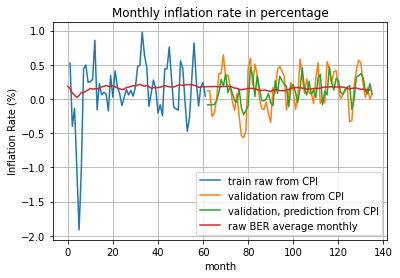

No handles with labels found to put in legend.


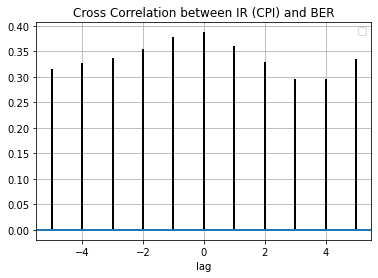

In [ ]:
#########################################        
# Plot all data of inflation rates
#########################################

##### Figure #####
fig18, ax18 = plt.subplots(1,1)
ax18.plot(count_train[1:], IR_prct_train, label="train raw from CPI")
ax18.plot(count_test, IR_prct_test, label="validation raw from CPI")
ax18.plot(count_test, pred_ir_test, label="validation, prediction from CPI")
ax18.plot(ann_mnly_count, ber_data, label="raw BER average monthly")
ax18.set(xlabel='month', ylabel='Inflation Rate (%)',
       title='Monthly inflation rate in percentage') 
ax18.legend(loc="lower right")
ax18.grid()
plt.show()
##### End Figure #####

### Plot Cross Correlation Function 

##### Figure #####
fig19, ax19 = plt.subplots(1,1)
ax19.xcorr(IR_prct_all, ber_data, usevlines=True, maxlags=5, normed=True, lw=2) 
#lw: line width

ax19.set(xlabel='lag',
       title='Cross Correlation between IR (CPI) and BER') 
ax19.legend(loc="upper right")
ax19.grid()
plt.show()
##### End Figure #####


## SARIMAX

In [ ]:
dftest=adfuller(IR_prct_all, autolag='AIC')
print("P-value= ", dftest[1])

ber_train=ber_data[0:61]
#convert IR_prct_all to panda dataframe
IR_pd=pd.DataFrame(IR_prct_train, columns=['IR'])

BER_pd=pd.DataFrame(ber_train, columns=['BER'])

df=IR_pd.join(BER_pd)

P-value=  0.016941091351472832


In [ ]:
len(ber_train)

61

In [ ]:
import pmdarima as pm

In [ ]:
sxmodel = pm.auto_arima(df[['IR']], exogenous=df[['BER']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=69.977, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=64.704, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=62.970, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=61.862, Time=0.13 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=63.301, Time=0.38 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=60.683, Time=0.18 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=59.075, Time=0.46 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=58.727, Time=1.20 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=1.37 sec
 AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   61
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 -22.364
Date:                            Tue, 23 Nov 2021   AIC                             58.727
Time:                                    21:24:31   BIC                             71.826
Sample:                                         0   HQIC                            63.677
                                             - 61                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BER            8.2333      1.492      5.518      0.000       5.309      11.158
ar.L1         -0.6197      0.169     -3.676      0.000      -0.950      -0.289
ar.L2         -0.5254      0.151     -3.469      0.001      -0.822      -0.229
ar.L3         -0.4645      0.179     -2.601      0.009      -0.815      -0.114
ar.S.L12      -0.6646      0.246     -2.705      0.007      -1.146      -0.183
ar.S.L24      -0.3153      0.215     -1.463      0.143      -0.738       0.107
sigma2         0.1285      0.036      3.615      0.000       0.059       0.198
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.73   Prob(JB):                         0.89
Heteroskedasticity (H):               0.36   Skew:                            -0.08
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
ber_test=ber_data[61:]
ber_test_1d=ber_test.reshape(74,1)
#ber_test_2d=np.transpose(np.concatenate((count_test, ber_test)).reshape(2,74))
n_periods = 74
fitted_test, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=ber_test_1d, 
                                  return_conf_int=True)
error_rmse_sarimax=mean_squared_error(IR_prct_test, fitted_test,squared=False)
error_mse_sarimax=mean_squared_error(IR_prct_test, fitted_test,squared=True)
print("SARIMAX RMSE= ",error_rmse_sarimax)
print("SARIMAX MSE= ",error_mse_sarimax)

SARIMAX RMSE=  0.3670709341892739
SARIMAX MSE=  0.13474107072658623


In [ ]:
len(count_test)
ber_test_2d=np.transpose(np.concatenate((count_test, ber_test)).reshape(2,74))



In [ ]:
len(ber_test)


74

In [ ]:
sxmodel2 = pm.auto_arima(df[['IR']], exogenous=df[['BER']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=1,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
sxmodel2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=51.897, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.918, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50.880, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50.304, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=75.683, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=51.239, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=52.406, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=60.513, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.931 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -21.152
Date:                Tue, 23 Nov 2021   AIC                             50.304
Time:                        22:22:30   BIC                             58.748
Sample:                             0   HQIC                            53.613
                                 - 61                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.9757      0.150     -6.506      0.000      -1.270      -0.682
BER            6.5365      0.976      6.694      0.000       4.623       8.450
ma.L1          0.3833      0.107      3.597      0.000       0.174       0.592
sigma2         0.1168      0.022      5.202      0.000       0.073       0.161
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.80   Prob(JB):                         0.96
Heteroskedasticity (H):               0.46   Skew:                             0.08
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
fitted_test2, confint = sxmodel2.predict(n_periods=n_periods, 
                                  exogenous=ber_test_1d, 
                                  return_conf_int=True)
error_rmse_sarimax2=mean_squared_error(IR_prct_test, fitted_test2,squared=False)
error_mse_sarimax2=mean_squared_error(IR_prct_test, fitted_test2,squared=True)
print("SARIMAX RMSE= ",error_rmse_sarimax2)
print("SARIMAX MSE= ",error_mse_sarimax2)

SARIMAX RMSE=  0.27066323523032837
SARIMAX MSE=  0.07325858690534806


In [ ]:
ber_train_1d=ber_train.reshape(61,1)
mod = sm.tsa.statespace.SARIMAX(ber_train, exog=ber_train_1d, order=(2,0,0), seasonal_order=(0,0,0,0))
fit_mod = mod.fit(disp=False, maxiter=250)
print(fit_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 644.990
Date:                Tue, 23 Nov 2021   AIC                          -1281.981
Time:                        23:17:10   BIC                          -1273.537
Sample:                             0   HQIC                         -1278.672
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0000         -0       -inf      0.000       1.000       1.000
ar.L1          0.5796    1.1e-19   5.27e+18      0.000       0.580       0.580
ar.L2          0.3840   1.11e-19   3.46e+18      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2968: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


In [ ]:
pred_mod = fit_mod.predict(start=61, end=134, 
                                  exog=ber_test_1d, 
                                  dynamic=True)
error_rmse_mod=mean_squared_error(IR_prct_test, pred_mod,squared=False)
error_mse_mod=mean_squared_error(IR_prct_test, pred_mod,squared=True)
print("Mod RMSE= ",error_rmse_mod)
print("Mod MSE= ",error_mse_mod)

Mod RMSE=  0.27763735458490846
Mod MSE=  0.07708250066090618


In [ ]:
sxmodel3 = pm.auto_arima(df[['IR']], exogenous=df[['BER']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=2,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=152.969, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=104.601, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=151.001, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=145.773, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=101.509, Time=0.38 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=124.492, Time=0.25 sec
 ARIMA(1,0,1)(2,1,0)[2] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,1)(2,1,0)[2] intercept   : AIC=98.294, Time=0.27 sec
 ARIMA(0,0,1)(1,1,0)[2] intercept   : AIC=98.439, Time=0.22 sec
 ARIMA(0,0,1)(2,1,1)[2] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,1